
# ECMWF Open Data — Introduction

This notebook shows how to **browse → download → explore → plot** a single forecast file from the public index at
`https://data.ecmwf.int/`, using **EarthKit** for loading and plotting.

**What you’ll do**
1. **Select** model, date (last 4 UTC days), run (00/06/12/18) and lead time (step). Only steps that **exist** are shown.
2. **Download** the chosen `.grib2` file locally.
3. **Explore** the file contents with a simple table (`ds.describe()`).
4. **Plot** the data using either the first or a specific parameter using **shortName** (e.g. `2t`, `msl`, `tp`).

**Useful references**
- ECMWF Open Data overview: https://www.ecmwf.int/en/forecasts/datasets/open-data  
- EarthKit (loading & plotting): https://earthkit.readthedocs.io/  
- GRIB format (what’s inside these files): https://confluence.ecmwf.int/display/UDOC/GRIB%3A+Edition+2


## 1) Setup & Imports

**What we do**
- Imports standard libs and modules.
- Prints EarthKit versions (useful for debugging).


In [1]:

from datetime import datetime, timedelta, timezone
from pathlib import Path
import re
import requests
from bs4 import BeautifulSoup

# EarthKit
import earthkit.data as ekd
import earthkit.plots as ekp
from earthkit.data import from_source
import matplotlib.pyplot as plt

print("earthkit-data:", ekd.__version__)
print("earthkit-plots:", getattr(ekp, "__version__", "unknown"))


earthkit-data: 0.16.0
earthkit-plots: 0.3.2



## 2) Helper functions (paths & discovery)

**What we do**
- Mirrors the public directory layout on `data.ecmwf.int`.
- Define **6 model families** and, for ENS models, multiple **product suffixes** to try (e.g., `enfo-ef`, `enfo-em`, `enfo-pf`, `enfo-cf`).
- Discovers which **steps** are available by parsing the live index page.
- Limit date options to a rolling archive of **previous 4 UTC days**.

**What you can edit**
- Add/rename model keys in `MODEL_MAP` (advanced users).
- Change the number of days in `recent_utc_dates(n=4)`.


In [2]:

BASE = "https://data.ecmwf.int/forecasts"

# Exactly 6 families; allow multiple candidate suffixes where needed
MODEL_MAP = {
    "ifs-single":  {"parts": ["ifs", "0p25", "oper"],         "suffixes": ["oper-fc"]},
    "ifs-ens":     {"parts": ["ifs", "0p25", "enfo"],         "suffixes": ["enfo-ef", "enfo-em", "enfo-cf", "enfo-pf"]},
    "aifs-single": {"parts": ["aifs-single", "0p25", "oper"], "suffixes": ["oper-fc"]},
    "aifs-ens":    {"parts": ["aifs-ens", "0p25", "enfo"],    "suffixes": ["enfo-em", "enfo-pf", "enfo-cf"]},
    "wave-single": {"parts": ["ifs", "0p25", "wave"],         "suffixes": ["wave-fc"]},
    "wave-ens":    {"parts": ["ifs", "0p25", "waef"],         "suffixes": ["waef-ef"]},
}

RUNS_UTC = ["00", "06", "12", "18"]

def yyyymmdd(dt): return dt.strftime("%Y%m%d")
def run_folder(hour): return f"{int(hour):02d}z"

def list_dir(url):
    """Return only .grib2 filenames in an index page."""
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    return [a.text.strip() for a in soup.find_all("a") if a.get("href", "").endswith(".grib2")]

def build_dir(date_str, run_str, model_key):
    parts = MODEL_MAP[model_key]["parts"]
    return f"{BASE}/{date_str}/{run_folder(run_str)}/" + "/".join(parts) + "/"

def available_steps(date_str, run_str, model_key):
    """Return (directory_url, steps_list, chosen_suffix). Tries suffixes in order."""
    durl = build_dir(date_str, run_str, model_key)
    files = list_dir(durl)
    for suf in MODEL_MAP[model_key]["suffixes"]:
        pat = re.compile(rf"{date_str}\d{{6}}-(\d+)h-{re.escape(suf)}\.grib2$")
        steps = sorted({int(m.group(1)) for f in files if (m := pat.match(f))})
        if steps:
            return durl, steps, suf
    # nothing found; return first suffix as default
    return durl, [], MODEL_MAP[model_key]["suffixes"][0]

def build_filename(date_str, run_str, step_h, suffix):
    ts = f"{date_str}{int(run_str):02d}0000"  # YYYYMMDDHHMMSS
    return f"{ts}-{int(step_h)}h-{suffix}.grib2"

def recent_utc_dates(n=4):
    today = datetime.now(timezone.utc).date()
    return [(today - timedelta(days=i)).strftime("%Y%m%d") for i in range(n)]



## 3) Select & Download (using widgets)

**What this does**
- Lets you choose **model**, **date** (last 4 days), **run** (00/06/12/18).  
- Auto-discovers only the **steps** that exist for that selection.  
- Shows the exact **file name** and **product** (e.g., `enfo-em`).  
- **Download file** saves to `data/<filename>.grib2` and stores the path in `target`.

**What you can edit**
- Just use the dropdowns. If you see **No steps found**, try an earlier run or previous UTC day.


In [ ]:

import ipywidgets as widgets
from IPython.display import display, Markdown

# rolling 4 UTC days (newest first)
date_opts = recent_utc_dates(4)

# widgets
model_dd = widgets.Dropdown(description="Model", options=list(MODEL_MAP.keys()), value="ifs-single")
date_dd  = widgets.Dropdown(description="Date (UTC)", options=date_opts, value=date_opts[0])
run_dd   = widgets.Dropdown(description="Run (UTC)", options=RUNS_UTC, value="12")
step_dd  = widgets.Dropdown(description="Step (h)", options=[], disabled=True)

download_btn = widgets.Button(description="Download file", button_style="primary", disabled=True)
out = widgets.Output()

# globals for later cells
target = None
date_str = run_str = model_key = None
step_h = None
dir_url = ""
product_suffix = None

def refresh_steps(*_):
    with out:
        out.clear_output()
        try:
            dstr, rstr, mkey = date_dd.value, run_dd.value, model_dd.value
            durl, steps, suf = available_steps(dstr, rstr, mkey)
            if not steps:
                step_dd.options = []; step_dd.disabled = True; download_btn.disabled = True
                print("No steps found. Try another date/run/model.")
                return

            step_dd.options = [str(s) for s in steps]
            step_dd.value = str(steps[0])
            step_dd.disabled = False
            download_btn.disabled = False

            # stash globals, including the picked product suffix
            global date_str, run_str, model_key, step_h, dir_url, product_suffix
            date_str, run_str, model_key = dstr, rstr, mkey
            step_h = int(step_dd.value)
            dir_url = durl
            product_suffix = suf

            fname = build_filename(date_str, run_str, step_h, product_suffix)
            display(Markdown(
                f"**Selected**: `{model_key}` — `{date_str}` `{run_str}` — step `{step_h}`  \n"
                f"**Product**: `{product_suffix}`  \n"
                f"**File**: `{fname}`"
            ))
        except Exception as e:
            step_dd.options = []; step_dd.disabled = True; download_btn.disabled = True
            print("Failed to list steps:", repr(e))

def on_step_change(change):
    if change.get("name") == "value" and change.get("new"):
        dstr, rstr, mkey = date_dd.value, run_dd.value, model_dd.value
        durl, _, suf = available_steps(dstr, rstr, mkey)
        global date_str, run_str, model_key, step_h, dir_url, product_suffix
        date_str, run_str, model_key = dstr, rstr, mkey
        step_h = int(change["new"])
        dir_url = durl
        product_suffix = suf
        with out:
            out.clear_output()
            fname = build_filename(date_str, run_str, step_h, product_suffix)
            display(Markdown(
                f"**Selected**: `{model_key}` — `{date_str}` `{run_str}` — step `{step_h}`  \n"
                f"**Product**: `{product_suffix}`  \n"
                f"**File**: `{fname}`"
            ))

def on_download(_):
    with out:
        out.clear_output()
        DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
        fname = build_filename(date_str, run_str, step_h, product_suffix)
        file_url = f"{dir_url}{fname}"
        global target
        target = DATA_DIR / fname

        print("Downloading:", file_url)
        try:
            with requests.get(file_url, stream=True, timeout=60) as r:
                r.raise_for_status()
                with open(target, "wb") as f:
                    for chunk in r.iter_content(1024 * 1024):
                        if chunk: f.write(chunk)
            print("Saved:", target, f"({target.stat().st_size/1e6:.1f} MB)")
        except Exception as e:
            target = None
            print("Download failed:", repr(e))

for w in (model_dd, date_dd, run_dd):
    w.observe(refresh_steps, names="value")
step_dd.observe(on_step_change, names="value")
download_btn.on_click(on_download)

display(widgets.VBox([
    model_dd,
    widgets.HBox([date_dd, run_dd]),
    step_dd,
    download_btn,
    out
]))
refresh_steps()



## 4) Explore

**What this does**
- Loads the downloaded file into EarthKit and prints a concise table of variables/levels/steps.
- You can use this table to find a **shortName** (e.g., `2t`, `msl`) for plotting in the next cell.


In [5]:

if target is None or not Path(target).exists():
    raise FileNotFoundError("No file downloaded yet. Use the Download button above first.")

ds = from_source("file", str(target))
ds.describe()


,,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,,
100u,heightAboveGround,100,20250830,1200,0,None,228246,od,oper,fc,0001
100v,heightAboveGround,100,20250830,1200,0,None,228247,od,oper,fc,0001
10u,heightAboveGround,10,20250830,1200,0,None,165,od,oper,fc,0001
10v,heightAboveGround,10,20250830,1200,0,None,166,od,oper,fc,0001
2d,heightAboveGround,2,20250830,1200,0,None,168,od,oper,fc,0001
2t,heightAboveGround,2,20250830,1200,0,None,167,od,oper,fc,0001
asn,surface,0,20250830,1200,0,None,32,od,oper,fc,0001
d,isobaricInhPa,"100,200,...",20250830,1200,0,None,155,od,oper,fc,0001
ewss,surface,0,20250830,1200,0,None,180,od,oper,fc,0001



## 5) Plot

**What you can do**:
- **Plot by shortName**: type a shortName from the table above (e.g., `2t`, `msl`, `tp`). 

Output()

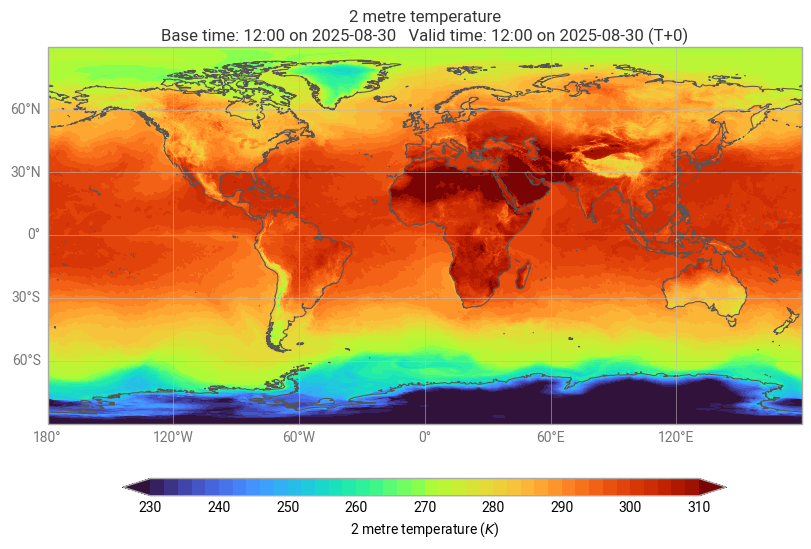

In [ ]:
import ipywidgets as widgets
from IPython.display import display

param = widgets.Text(description="shortName", placeholder="e.g. 2t, msl, tp")
plot_btn = widgets.Button(description="Plot", button_style="primary")
out = widgets.Output()

def _plot(_):
    with out:
        out.clear_output()
        name = (param.value or "").strip().lower()
        if not name:
            print("Type a shortName you see in the Explore table above (e.g. 2t, msl, tp).")
            return
        # pick the first field matching this shortName (case-insensitive)
        for i, f in enumerate(ds):
            sn = (f.metadata().get("shortName") or "").lower()
            if sn == name:
                try:
                    ekp.quickplot(ds[i])
                except Exception as e:
                    print("Plot failed for this field:", repr(e))
                return
        print(f"shortName '{param.value}' not found. Check the Explore table and try again.")

plot_btn.on_click(_plot)
display(widgets.HBox([param, plot_btn]), out)



---
### Troubleshooting
- **No steps found**: the chosen run may not be available yet — try an earlier run or previous UTC day.
- **AIFS/IFS ENS quirks**: some runs publish `enfo-em/pf/cf` rather than `enfo-ef`. The selector tries these automatically.
- **Plot by shortName**: use the exact `shortName` shown in the explore table.


## Next notebook: Advanced downloads & plotting

In the next notebook we will move away from from simple HTTP browsing and explore the **ECMWF Open Data Python client** (`ecmwf-opendata`) to cover:
- Programmatic requests with **batch** downloads and **step ranges/lists**
- Multi-parameter + **pressure-level** retrieval; **ENS** products (CF/PF/EM/EF) and waves
- Exploring data with EarthKit (metadata filters, safe selection) and plotting for **multiple steps/params**
- Practical tips: **skip re-downloads**, batch steps, **filter before decode**, close figures, keep a structured `data/` cache, and **pin library versions** for reproducibility
